# SPT Tutorial

This document describes my recommended approach for Single Particle Tracking and subsequent results analysis.
4/7/19

The general pipeline outline: 

- data quality checks 
    - SNR 
    - Density 

- SPT: trackntrace 
    - localization: 
    - localization refinement: 
    - linking: utrack 
    
- analysis: TrackPy 
    - track filtering 
    - vizualization (video/picture) 
    - drift 
    - diffusion coef calc
    
For this tutorial, we'll be using the data: '../data/180920_Cs1C2_CAD_JFHaloLifeactRac_14ms_2Kfr_02-CROPPED'

In [1]:
%matplotlib inline

import trackpy as tp
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sbn 
import sys 
import os
import evans_SPT_lib as spt # needs to be in same folder as this file. or added to python lib
import time
import pandas as pd
from matplotlib import animation
import statsmodels.formula.api as sm
import pims
from scipy.io import loadmat
import math
from sklearn.manifold import TSNE
import statsmodels.api as sm

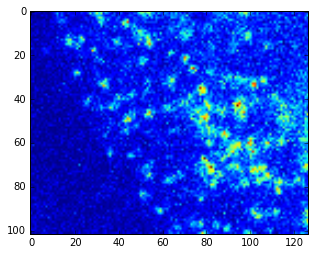

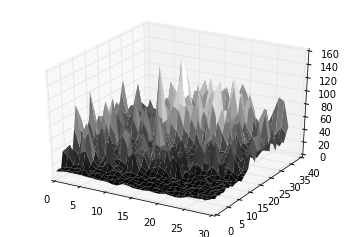

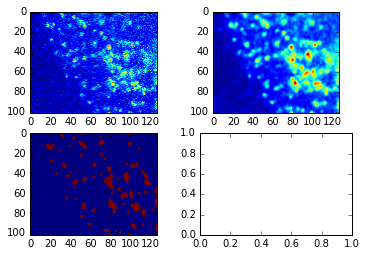

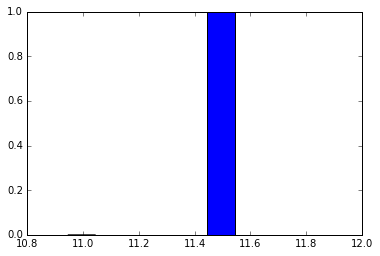

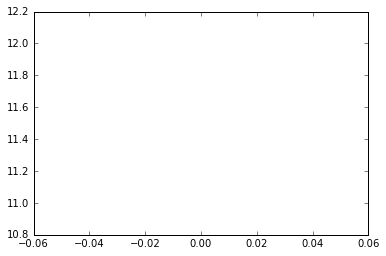

'\ntic = time.time()\ndata.gen_SNR_hist(n=2000, show_imgs=False) # change to n=2000 for all frames\ntime.time() - tic\n'

In [2]:
# Data Quality Checks 

# load data 
# 180920_Cs1C3_CAD_JFHaloLifeactRac_10ms_2Kfr <- TRY THID ONE NEXT 
data = spt.tif_img('./../data/180920_Cs1C2_CAD_JFHaloLifeactRac_14ms_2Kfr_02-CROPPED.tif')

plt.imshow(data.img[0])
plt.show()

# if you run this function outside of jupyter notebook, you get an interactive 3d plot. change downscale parameter for smoothing
data.plot3D(downscale=0.3)

# viz the SNR masks - diagnostic 
tic = time.time()
data.gen_SNR_hist(n=1, show_imgs=True)
time.time() - tic

'''
tic = time.time()
data.gen_SNR_hist(n=2000, show_imgs=False) # change to n=2000 for all frames
time.time() - tic
'''
# TODO: Characterize particle density 

# SPT 

Now we use trackntrace to generate SPT track results. 

To begin, open matlab and start the trackntrace GUI. 

![step1](./imgs/tnt1.png)

Press the + button, navigate to .tif stack and select. 

![step2](./imgs/tnt2.png)

Set the output file path: C:\Users\natha\Box Sync\Galbraith_Research\tutorial_tnt_outputs
Set Candidate Detection Method - default
Set Refinement method - default
Set Tracking: utrack 

![step3](./imgs/tnt3.png)

Hit 'Preview', examine/tune parameters using this preview results. 
When results are satisfactory, hit 'Start Processing'

In [6]:
# Load Data in 

TNT_OUTPUT_PATH = './../tutorial_tnt_outputs'
TNT_OUTPUT_NAME = '180920_Cs1C2_CAD_JFHaloLifeactRac_14ms_2Kfr_02-CROPPED_2019-m04-d07-18h59_TNT.mat'

# load mat returns the data as a dictionary 
sptRes = loadmat(TNT_OUTPUT_PATH + '/' + TNT_OUTPUT_NAME)

# id, frame, x, y, z, amplitude - for trackpy, let particle = id
_tracks = pd.DataFrame(sptRes['trackingData'], columns = ['particle', 'frame', 'x', 'y', 'z', 'amplitude'] )

_tracks.head() # id is track id, unique with frame, isn't reused one track dyes 


,particle,frame,x,y,z,amplitude
0,1,1,99.557596,12.195633,0,427.162361
1,1,2,99.611724,12.576921,0,488.880319
2,1,3,99.926855,12.791693,0,453.120384
3,1,4,99.933305,12.376401,0,566.598899
4,1,5,99.612900,12.739113,0,413.413640


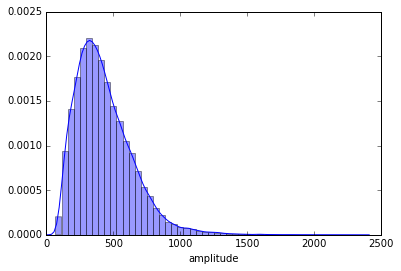

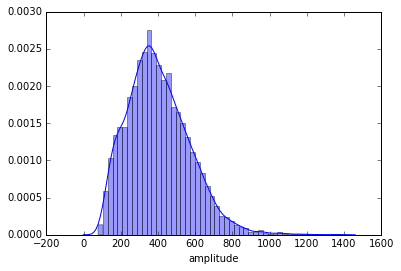

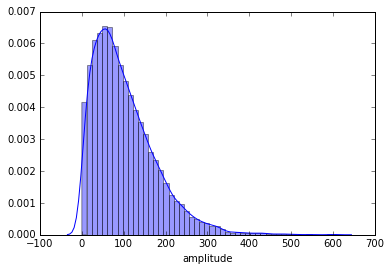

In [7]:
# We can also filter trajectories by their appearance. At this stage, with trajectories linked, we can look at a feature's "average appearance" throughout its trajectory, giving a more accurate picture.
plt.figure()
sbn.distplot(_tracks['amplitude'])
plt.show() 

plt.figure()
means = _tracks.groupby('particle').mean()
sbn.distplot(means['amplitude'])
plt.show()

plt.figure()
std = _tracks.groupby('particle').std()
sbn.distplot(std['amplitude'])
plt.show()

In [8]:
# Filter stubs 
before = len(set(_tracks['particle']))
minimum_track_length = 5
tracks = tp.filter_stubs(_tracks, minimum_track_length)
tracks = tracks.reset_index(drop=True)
after =  len(set(tracks['particle']))
print('before: %d \nafter: %d \ndropped: -%d' %(before,after,(before-after)))

before: 11378 
after: 4720 
dropped: -6658


starting aggregate detection on 54290 localizations
beginning clustering...
Using eps of 0.275 [30.53 nm] - does that sound right? ~30nm is default.


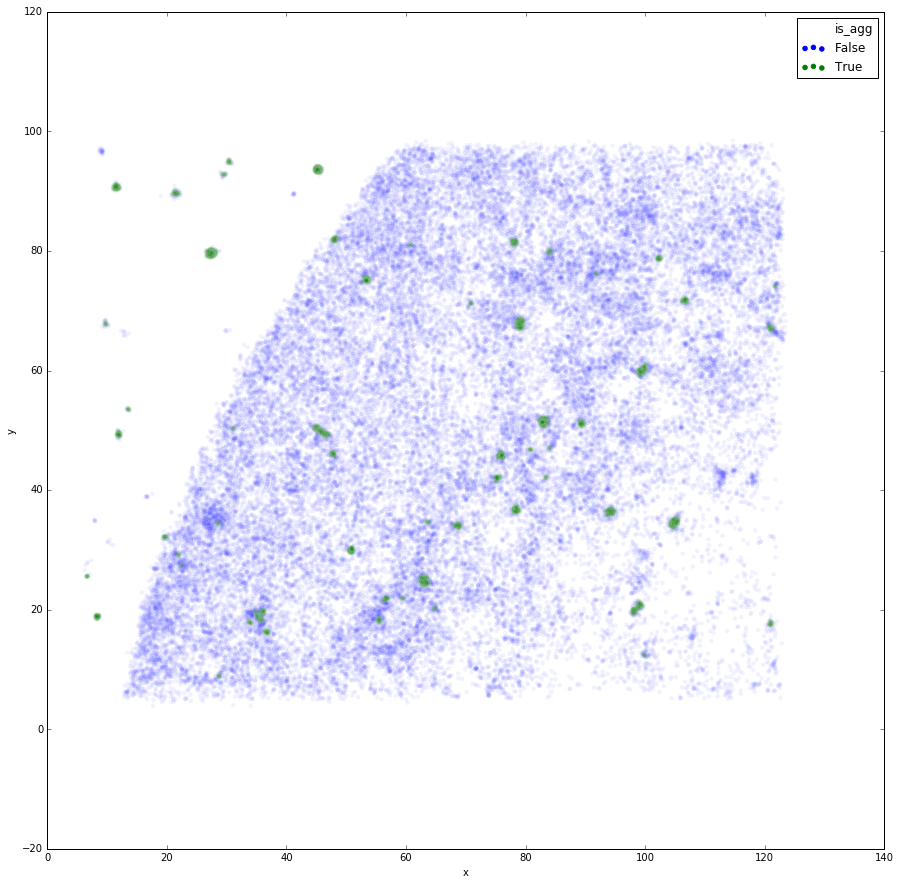

clustering complete. 7201 localizations labeled as aggregate.


In [9]:
# detect aggregates
tracks = spt.detect_aggregations(tracks, n=15, plot=True)

# Track Feature Analysis

In [10]:
track_feats = spt.calculate_track_features(tracks)
track_feats.head()

beginning feature extraction, are your mappings correct?
using pixel mapping of 111 nm/px...
using time mapping of: 0.014000 sec/frame
calculating track features: 0 / 4720 complete
LINEAR MODEL IS SMALLER BY: -1.65
LINEAR MODEL IS SMALLER BY: -2.66
QUADRATIC MODEL IS BEST BY: -4.21
QUADRATIC MODEL IS BEST BY: -9.97
QUADRATIC MODEL IS BEST BY: -3.04
QUADRATIC MODEL IS BEST BY: -6.31
LINEAR MODEL IS SMALLER BY: -2.34
QUADRATIC MODEL IS BEST BY: -7.00
LINEAR MODEL IS SMALLER BY: -1.66
QUADRATIC MODEL IS BEST BY: -3.07
QUADRATIC MODEL IS BEST BY: -5.23
QUADRATIC MODEL IS BEST BY: -5.31
QUADRATIC MODEL IS BEST BY: -4.67
QUADRATIC MODEL IS BEST BY: -3.09
QUADRATIC MODEL IS BEST BY: -10.31
QUADRATIC MODEL IS BEST BY: -1.30
QUADRATIC MODEL IS BEST BY: -5.37
QUADRATIC MODEL IS BEST BY: -4.37
QUADRATIC MODEL IS BEST BY: -21.94
QUADRATIC MODEL IS BEST BY: -58.86
QUADRATIC MODEL IS BEST BY: -12.60
QUADRATIC MODEL IS BEST BY: -6.96
QUADRATIC MODEL IS BEST BY: -7.37
QUADRATIC MODEL IS BEST BY: -5.66

KeyboardInterrupt: 

In [ ]:
print('feature  |   Description')
print('-------------------------------------------------------------------------------------------------')
for feat in track_feats.Data_Dictionary: 
    print(feat + '  ::  ' + track_feats.Data_Dictionary[feat]) 
    print('-------------------------------------------------------------------------------------------------')

In [ ]:
#track_feats.diffusion_coef
fig, axs = plt.subplots(1,4, figsize= (30,10))

# Published Diffusion Coef of G-actin in Cytoplasm from B10 Numbers [3-30 um^2/s] -> [3e6-30e6 nm/s]
sbn.distplot(list(track_feats['diffusion_coef']), kde=False, ax=axs[0]).set_title('diffusion_coef')

sbn.distplot(list(track_feats['D_aic']), kde=False, ax=axs[1]).set_title('D reg AIC')

sbn.distplot(list(track_feats['D_r2']), kde=False, ax = axs[2]).set_title('D reg R-squared')

sbn.distplot([x for x in track_feats['D_p'] if not math.isnan(x)], kde=False, ax= axs[3]).set_title('D reg F-statisitc p-value')

print('mean diffusion coef: %f um^2/s' %(np.mean(np.array(track_feats['diffusion_coef']))/1e6))

In [ ]:
# Published Diffusion Coef of G-actin in Cytoplasm from B10 Numbers [3-30 um^2/s] -> [3e6-30e6 nm/s]
fig = plt.figure(figsize=(10,10))
plt.xlim(-3, 50)
sbn.distplot([D for D in track_feats['diffusion_coef']], kde=True, hist=False).set_title('diffusion_coef')
plt.axvline(3, color='red')
plt.axvline(30, color='red')
plt.axvline(np.mean(np.array(track_feats['diffusion_coef'])), color='green')
plt.show()

above = len([x for x in track_feats['diffusion_coef'] if x > 30])
in_ = len([x for x in track_feats['diffusion_coef'] if x < 3])
below = len([x for x in track_feats['diffusion_coef'] if x < 30 and x > 3])
total = above + in_ + below

print('number tracks below/in/above: %d  %d  %d' %(below,in_,above))
print('proportion tracks below/in/above: %.2f  %.2f  %.2f' %(below/total, in_/total, above/total))

In [ ]:
#track_feats.diffusion_coef
fig, axs = plt.subplots(1,3, figsize= (30,10))
sbn.distplot(list(track_feats['avg_speed']), kde=False, ax=axs[0]).set_title('average track speed')

sbn.distplot(list(track_feats['min_speed']), kde=False, ax=axs[1]).set_title('min track speed')

sbn.distplot(list(track_feats['max_speed']), kde=False, ax = axs[2]).set_title('max track speed')


Max track speed looks like it might be multimodal. It'd be interesting to try fitting a mixed gaussian model to it. 

Strange that min track speed has observations with such a high value... few ALWAYS fast particles? 

In [ ]:
#track_feats.diffusion_coef
fig, axs = plt.subplots(1,3, figsize= (30,10))
sbn.distplot(list(track_feats['lambda1']), kde=False, ax=axs[0]).set_title('PC1 variance')

sbn.distplot(list(track_feats['lambda2']), kde=False, ax=axs[1]).set_title('PC2 variance')

sbn.distplot([x for x in track_feats['evection_mag'] if x < 100], kde=False, ax = axs[2]).set_title('evection mag: Major axis variance / minor axis variance')

In [ ]:
fig, axs = plt.subplots(1,3, figsize= (30,10))
sbn.distplot(list([x for x in track_feats['length'] if x < 40]), kde=False, ax=axs[0]).set_title('track length')

sbn.distplot(list(track_feats['track_dist']), kde=False, ax=axs[1]).set_title('total track displacement')

sbn.distplot([np.arctan(y/x) for x,y in track_feats['dir']], kde=False, ax = axs[2]).set_title('direction (theta)')



In [ ]:
plt.figure(figsize=(10,10))
sbn.distplot(track_feats['percent_aggregate'], kde=False, hist=True)
plt.show()

Filter 
    length < 50 
    track_disp < 60 
    
Evection magnitude needs to be filtered to remove large values so we can see the actual dist. 
    -> looks multimodal  
    
    
To make sure we are using Diffusion coefficients that are calculated by a well fit model, I suggest that we 
Filter by:   
    p < 0.05   - see next VV 
    R2 > 0.5  - might be worthwhile filtering tracks based on expected behavior 
    AIC <  ?   - not good comparison between models of different data
    Diffusion Coef - outside of expected bounds? 3-30um^2/s (what is our goal here?)
    
BUT We should try to separate out the bound particles first anyway, because a lot of this misfit data is probably resulting from bound flurophores. 


In [ ]:
# Going to try and do clustering to isolate bound vs unbound 

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
X = track_feats[ ['length', 'track_dist', 'evection_mag', 'avg_speed', 'min_speed', 'max_speed', 'diffusion_coef', 'D_p', 'D_r2'] ]

X = X.dropna()
X.head()
tsne_results = tsne.fit_transform(X)

In [ ]:
x = [x[0] for x in tsne_results]
y = [x[1] for x in tsne_results]
plt.plot(x,y, '*', alpha =0.1)

In [ ]:
# see if we can see any directional movement
pcx = [x[0] for x in track_feats['PC1']]
pcy = [x[1] for x in track_feats['PC1']]

plt.plot(pcx, pcy, '.', alpha=0.005)

In [ ]:
# FILTER AND SUBSET

filter_criteria = ( track_feats['length'] < 50) & (track_feats['track_dist'] < 8000)
        
feat_filtered = track_feats.loc[filter_criteria]

print ('filter dropped %d tracks' %(len(feat_filtered) - len(track_feats)))

selection_criteria = [x for x in (feat_filtered['diffusion_coef'] < 0)
                      | (feat_filtered['track_dist'] < 400) 
                      | (feat_filtered['avg_speed'] < 7000)
                      | (feat_filtered['percent_aggregate'] > 0)]

bound = feat_filtered.loc[selection_criteria]
free = feat_filtered.loc[[not x for x in selection_criteria]]

print('bound count: %d' %len(bound))
print('free count: %d' %len(free))
print('percent_bound: %f' %(len(bound)/(len(bound)+ len(free))))

In [ ]:
# Published Diffusion Coef of G-actin in Cytoplasm from B10 Numbers [3-30 um^2/s] -> [3e6-30e6 nm/s]
fig = plt.figure(figsize=(10,10))
#plt.xlim(0,0.8e8)
sbn.distplot([D for D in free['diffusion_coef'] ], kde=False, hist=True, color='orange').set_title('diffusion_coef')
sbn.distplot([D for D in bound['diffusion_coef'] ], kde=False, hist=True, color='blue').set_title('diffusion_coef')
plt.axvline(3, color='red')
plt.axvline(30, color='red')
plt.axvline(np.mean(np.array(track_feats['diffusion_coef'])), color='green')
plt.show()

above = len([x for x in track_feats['diffusion_coef'] if x > 30])
below = len([x for x in track_feats['diffusion_coef'] if x < 3])
in_ = len([x for x in track_feats['diffusion_coef'] if x < 30 and x > 3])
total = above + in_ + below

print('number tracks below/in/above: %d  %d  %d' %(below,in_,above))
print('proportion tracks below/in/above: %.2f  %.2f  %.2f' %(below/total, in_/total, above/total))

In [ ]:
boundTracks = tracks[tracks['particle'].isin(list(bound.index))]
print('bound tracks %d ' %len(boundTracks))
print('all tracks %d' %len(tracks))
print('proportion bound: %.2f' %(len(boundTracks)/len(tracks)))

fig, ax = plt.subplots(1,2,figsize=(25,10), sharey=True)
tp.plot_traj(boundTracks, ax=ax[0])
ax[0].set_title('bound tracks')

x = list(boundTracks['x'])
y = list(boundTracks['y'])

ax[1].plot(x,y,'.', alpha=0.05)
ax[1].set_title('bound localizations')
plt.show()

In [ ]:
freeTracks = tracks[tracks['particle'].isin(list(free.index))]

print('bound tracks %d ' %len(freeTracks))
print('all tracks %d' %len(tracks))
print('proportion bound: %.2f' %(len(freeTracks)/len(tracks)))

fig, ax = plt.subplots(1,2,figsize=(25,10), sharey=True)
tp.plot_traj(freeTracks, ax=ax[0])
ax[0].set_title('free tracks')

x = list(freeTracks['x'])
y = list(freeTracks['y'])

ax[1].plot(x,y,'.', alpha=0.05)
ax[1].set_title('free localizations')
plt.show()


In [ ]:
fig = plt.figure(figsize=(20,20))
plt.xlim(0,100)
plt.ylim(0,100)
for _id in list(set(freeTracks['particle'])): 
    aTrack = freeTracks[freeTracks['particle'] == _id]
    x = aTrack['x']
    y = aTrack['y']
    plt.plot(x, y, alpha = 0.15, color = 'blue')

x = list(freeTracks['x'])
y = list(freeTracks['y'])

plt.plot(x,y,'.', alpha=0.05, color='red')

x = list(boundTracks['x'])
y = list(boundTracks['y'])

plt.plot(x,y,'.', alpha=0.05, color='green')

plt.show()

In [ ]:
pc1x = np.array([x[0] for x in free['PC1']])
pc1y = np.array([x[1] for x in free['PC1']])

theta = np.arctan(pc1y / pc1x) + np.pi/2
theta /= np.max(np.abs(theta),axis=0) # normalize for color palette 
#C = plt.get_cmap('viridis')
ind = free.index

theta_d = {}

print(min(theta))
print(max(theta))


for t, i in zip(theta, ind):
    theta_d[i] = t

pids = np.array(freeTracks['particle'])
track_thetas = [theta_d[x] for x in pids]

freeTracks['PC1_color'] = pd.Series(track_thetas, index = freeTracks.index)


plt.figure(figsize=(15,15))
'''
IDS = list(set(freeTracks['particle']))
for i,_id in enumerate(IDS):
    if (i%int((len(IDS)/5)) == 0): 
        print('plotting ... %d / %d complete' %(i, len(IDS)))
    dat = freeTracks[(freeTracks['particle'] == _id)]
    sbn.lineplot(x='x', y='y', hue='PC1_color', data=dat, alpha=0.3)
'''
sbn.lineplot(x='x', y='y', hue='PC1_color', data=freeTracks, alpha=0.15, markers=True, palette='brg').set_title('Free Tracks Colored Direction')

plt.show()

In [ ]:
# do particle movement differ significantly between bound and evective? They should

fig, axs = plt.subplots(1,4, figsize= (30,10))

sbn.distplot([np.arctan(y/x) for x,y in bound['dir']], kde=False, ax = axs[0]).set_title('Bound direction (theta)')
sbn.distplot([np.arctan(y/x) for x,y in bound['PC1']], kde=False, ax = axs[1]).set_title('Bound PC (theta)')
sbn.distplot([np.arctan(y/x) for x,y in free['dir']], kde=False, ax = axs[2]).set_title('Free direction (theta)')
sbn.distplot([np.arctan(y/x) for x,y in free['PC1']], kde=False, ax = axs[3]).set_title('Free direction (theta)')


In [ ]:

mpp = 0.111 # microns per pixel
fps = 1/0.014 # frames per second 
em = tp.emsd(freeTracks, mpp, fps)

fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(1e-2, 100))
a = tp.utils.fit_powerlaw(em)
plt.show()

In [ ]:
# GOLD
# https://physics.nyu.edu/grierlab/methods/node11.html

MSDs = np.array(em)[0:25]

X = np.array(em.index)[0:25]
X2 = sm.add_constant(X)
model = sm.OLS(MSDs,X)
results = model.fit()
D = results.params[0] # um^2 / frame
aic = results.aic
p = results.f_pvalue
r2 = results.rsquared

print('Diffusion coef: %f' %D)

plt.figure()
plt.plot(X, MSDs, '*')
plt.show()

print(results.summary())

In [ ]:
print(a)
D = 4 * a['A']
print(D)

In water, a viscous material, the expected power-law exponent n=1. The value of A=4D, where D is the particles’ diffusivity. D is related to viscosity η, particle radius a, and temperature T as

$$ D=\frac{kT}{6πηa} $$

For particles with a 1 μm diameter in room-temperature water, A≈1.66. Our value above is not far off.

So... 

$$ D_{measured} = 4 (5.164) = 20.656 $$

T = ~300 K 
n = .0091 Poise (water ish) 
a = ~ 10 nm




Compare to: Water (g) – air (g)	| 25 | 	D = 0.28

Seems unlikely... so either a mark for evective flow, or our data is widely off. 


In [ ]:
(8.99e9) * (300) / (6 * 3.1415926 * 0.0091 * 10e-9)

In [ ]:


d = tp.compute_drift(freeTracks)

d2 = d.assign(r = lambda this: np.sqrt(this.x**2 + this.y**2), theta = lambda this: np.arccos( this.x/this.r) ) 
d.head()

plt.figure()
d2.plot();
plt.show()

plt.figure()
d2['theta'].plot();
plt.show()

In [ ]:
tracks.head()
tracks2= tracks.copy()
tracks2.columns = ['trajectory','frame', 'x','y','z','amplitude']
tracks2 = tracks2.assign(t=tracks2['frame']*(14/1000))
tracks2 = tracks2.assign(x=tracks2['x']*0.111) # convert pixels to um
tracks2 = tracks2.assign(y=tracks2['y']*0.111) # convert pixels to um
tracks2.to_csv('./tracks_for_spoton.csv', index=False)
tracks2.head()

In [ ]:
driftless_free = tp.subtract_drift(freeTracks)
tp.plot_traj(driftless_free)

In [ ]:
# what is this part doing, and what is 100/285? 
em = tp.emsd(driftless_free, 100/285., 14)

# this is SUPPOSED to be linear - need to read about what this is trying to show 

fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(1e-2, 100))
a = tp.utils.fit_powerlaw(em)
plt.show()

In [ ]:
a

III. OPTIMIZED LEAST-SQUARE FIT OF THE MSD
As mentioned above, one of the most popular approaches to SPT data analysis involves computing the so-called mean-square displacement (MSD) curve of the trajectory and fitting it with the appropriate dynamic model. Among different possible definitions of the MSD, we consider the most commonly used:

ρ¯n=1N−n∑i=1N−n(r⃗ i+n−r⃗ i)2, n=1,…,N−1,
(9)
where r⃗ i, i ∈ {1, …, N} is the measured position of the particle in frame i. The MSD curve represents the average square distance traveled by the particle after different time lags iΔt. For an isotropic free diffusion regime in d dimensions, the theoretical MSD curve grows linearly with time, the slope of the curve being proportional to the diffusion coefficient D:

ρ(iΔt) = 2d(σ2 − 2RDΔt) + 2dDiΔt.	(10)
Equation (10) can be normalized by the average single-frame mean square displacement 2dDΔt to obtain

ρ(iΔt)2dDΔt=(σ2DΔt−2R)+i=x+i,
(11)
which identifies the reduced square localization error x defined in the previous section as the offset of the normalized MSD curve. When R = 0, a small value of x (x < 1) indicates a regime where the dynamic localization error σ is small compared to the mean displacement due to diffusion during a single frame duration, 2dDΔt−−−−−−√.

Although a linear fit to the experimental MSD curve should provide a good estimate of D, the problem is complicated by the increased variance and correlated values of the MSD at large time lags, as noted originally [24,33]. This suggests using only the first few points of the MSD curve in order to reduce the influence of the large variance of the later MSD points. How few points to use has remained largely an empirical decision and varies from author to author. It was recently recognized that the MSD variance is also severely affected at short time lags by dynamic localization error σ and motion blur R [20,21] (the explicit expression for the MSD variance and covariance for arbitrary dimension d including dynamic localization error and motion blur is provided in Appendix C for reference). The increased variance of the MSD curve at short time lags is particularly noticeable when the reduced square localization error x is larger than 1, and results in poor MSD fits if only small time lags are used for the fit, as is often practiced. This suggested that there exists an optimal number pmin of MSD points to use (depending on the reduced parameter x as well as on the number of trajectory points N) in order to obtain the smallest uncertainty on the fitted parameter D.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4917385/



# THE OG OLS MSD diffusion coef paper 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3055791/
-> If we use this, should reference this paper 